# BigDL-Nano Training Demo
This demo illustrates how to use BigDL-Nano to acclerate model training in a [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) based application. This notebook is modified from the original [FastFace training example](https://github.com/borhanMorphy/fastface/blob/master/doc_samples/training.py) which shows how to train a face detection model from scratch on the [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). 

In this demo, with all the optimizations provided by BigDL-Nano, we could achieve 3x times faster than the official Pytorch Lightning code in only 1 line of change.

In [1]:
# from pytorch_lightning import Trainer
from bigdl.nano.pytorch.trainer import Trainer

### Just 1-line of code change to use BigDL-Nano

To use BigDL-Nano to acclerate training, the only change we made to the original PyTorch Lightning code is to replace the original import of `pytorch_lightning.Trainer` with `bigdl.nano.pytorch.trainer.Trainer`, as shown below.

Under the hood, a set of training optimizations (e.g., ISA vectorization, improved memory allocation, multi-processing, optimizations in Intel Extension for PyTorch, etc.) are automatically enabled. 

For more details, you may refer to [BigDL 2.0 paper](https://arxiv.org/abs/2204.01715) and [BigDL-Nano docs](circuit.intel.com/content/news/home/circuithome.html).


In [2]:
import time
import pytorch_lightning as pl
import fastface as ff
import imageio
from PIL import Image
# set seed
pl.seed_everything(41)

Global seed set to 41


41

### Training

#### step 1： define train and val dataset (FDDB)

If you are running for the first time, you need to wait for a while, the code will automatically download the dataset from [originalPics](http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz) and [FDDB-folds](http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz) to the cache directory "~/.cache/fastface/0.1.3/data/fdbb/"

In [3]:
# build training transforms
train_transforms = ff.transforms.Compose(
    ff.transforms.Interpolate(target_size=480),
    ff.transforms.Padding(target_size=(480, 480)),
    ff.transforms.RandomHorizontalFlip(p=0.5),
)

# build val transforms
val_transforms = ff.transforms.Compose(
    ff.transforms.Interpolate(target_size=480),
    ff.transforms.Padding(target_size=(480, 480)),
)

# build torch.utils.data.DataLoader for training
train_dl = ff.dataset.FDDBDataset(
    phase="train", transforms=train_transforms
).get_dataloader(batch_size=8, shuffle=True, num_workers=8)

# build torch.utils.data.DataLoader for validation
val_dl = ff.dataset.FDDBDataset(phase="val", transforms=val_transforms).get_dataloader(
    batch_size=8, shuffle=False, num_workers=8)

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### step2 : define face detection model

In [4]:
# define preprocess dict
preprocess = {"mean": 127.5, "std": 127.5, "normalized_input": False}

# define hyper parameter dict
hparams = {
    "learning_rate": 0.1,
    "momentum": 0.9,
    "weight_decay": 0.00001,
    "milestones": [500000, 1000000, 1500000],
    "gamma": 0.1,
    "ratio": 10,
}

arch = "lffd" # Light and Fast Face Detector
# option range : ["original", "slim"]
config = "slim"
# config = "original"
# build pl.LightningModule with random weights
model = ff.FaceDetector.build(
    arch, config=config, preprocess=preprocess, hparams=hparams
)

# add average precision pl.metrics.Metric to the model
model.add_metric("average_precision", ff.metric.AveragePrecision(iou_threshold=0.5))

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Metric` was deprecated since v1.3.0 in favor of `torchmetrics.metric.Metric`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


#### step3 : define trainer and start training

In [5]:
model_save_name = "{}_{}_{}_best".format(arch, config, "fddb")
ckpt_save_path = "./checkpoints"

# define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=ckpt_save_path,
    verbose=False,
    filename=model_save_name,
    monitor="metrics/average_precision",
    save_top_k=1,
    mode="max",  # only pick max of `average_precision`
    save_last=False
)

# define bigdl-nano Trainer
trainer = Trainer(
    default_root_dir=".",
    accumulate_grad_batches=4,  # update weights every 4 batches
    callbacks=[checkpoint_callback],
    gpus=0,
    precision=32,
    max_epochs=100,
    check_val_every_n_epoch=2,  # run validation every 2 epochs
    gradient_clip_val=10,  # clip gradients
)

# start trainings
start_t = time.time()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=[val_dl])
end_t = time.time()
print("training with nano cost {:.2f}s at all.".format(end_t - start_t))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:532: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."

  | Name | Type | Params
------------------------------
0 | arch | LFFD | 1.5 M 
------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.080     Total estimated model params size (MB)


Global seed set to 41


Epoch 0:   0%|          | 0/250 [00:00<00:00, 909.24it/s]   

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'reg_loss', 'cls_loss'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Epoch 1:   0%|          | 0/357 [00:00<00:00, 1602.71it/s, loss=0.428, v_num=0] 

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:689: UserWarning: ModelCheckpoint(monitor='metrics/average_precision') not found in the returned metrics: ['loss/training', 'cls_loss/training', 'reg_loss/training']. HINT: Did you call self.log('metrics/average_precision', value) in the LightningModule?
  warning_cache.warn(m)


Epoch 99: 100%|██████████| 357/357 [01:42<00:00,  3.49it/s, loss=0.0139, v_num=0] 
training with nano cost 8658.08s at all.


We have trained lffd_slim and llfd_original model on a machine with 4 Intel(R) Xeon(R) Platinum 8380H CPUs, each with 28 cores. BigDL-Nano can bring 3.6x and 3.5x speedup for the two model training respectively, as shown in below tables.

Training performance (lffd_slim model)：

|  | pl.Trainer | bigdl.nano.pytorch.Trainer |
| :-----| ----: | :----: |
| train time per epoch | 4.5min | 1.5min |
| train+val time per epoch | 5.5min | 2min |
| total time | 8.7h | 2.4h |
| speedup | 1x | 3.6x | 
| val average precision | 85.54% | 86.85% |

Training performance (lffd_original model)：

|  | pl.Trainer | bigdl.nano.pytorch.Trainer |
| :-----| ----: | :----: |
| train time per epoch | 5min50s |1.5min | 
| train+val time per epoch | 7min | 2.1min |  
| total time | 10.8h | 3.1h | 
| speedup | 1x | 3.5x | 
| val average precision | 87.68% | 87.68% |

### Test

#### step 1： define dataset 

In [4]:
# build transforms
transforms = ff.transforms.Compose(
    ff.transforms.Interpolate(target_size=480),
    ff.transforms.Padding(target_size=(480, 480)),
)

# build torch.utils.data.Dataset
ds = ff.dataset.FDDBDataset(phase="test", transforms=transforms)

# build torch.utils.data.DataLoader
dl = ds.get_dataloader(batch_size=1, num_workers=0)

step 2： load model

If you have completed the above training process, you can load your trained model by `model = ff.FaceDetector.load_from_checkpoint("./checkpoints/lffd_slim_fddb_best.ckpt")`

If you don't want to train for yourself, you can also load the pre-trained model directly by `model = ff.FaceDetector.from_pretrained("lffd_slim")`

In [5]:
# build pl.LightningModule using pretrained weights
# model = ff.FaceDetector.from_pretrained("lffd_slim")
model = ff.FaceDetector.load_from_checkpoint("./checkpoints/lffd_slim_fddb_best.ckpt")

# set model to eval mode
model.eval()

# add average precision pl.metrics.Metric to the model
model.add_metric("average_precision", ff.metric.AveragePrecision(iou_threshold=0.5))

/opt/anaconda3/envs/nano3/lib/python3.7/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Metric` was deprecated since v1.3.0 in favor of `torchmetrics.metric.Metric`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


step 3: test

In [6]:
# define nano.Trainer for testing
trainer = Trainer(
    benchmark=True,
    logger=True,
    checkpoint_callback=False,
    gpus=0,
    precision=32,
)

# run test
trainer.validate(model, dataloaders=[dl])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/anaconda3/envs/nano3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 224 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Validating: 100%|██████████| 2845/2845 [01:47<00:00, 28.15it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'cls_loss/validation': 0.04566631093621254,
 'loss/validation': 0.05316464230418205,
 'metrics/average_precision': 0.9246447682380676,
 'reg_loss/validation': 0.0074983155354857445}
--------------------------------------------------------------------------------


[{'loss/validation': 0.05316464230418205,
  'cls_loss/validation': 0.04566631093621254,
  'reg_loss/validation': 0.0074983155354857445,
  'metrics/average_precision': 0.9246447682380676}]

We have tested lffd_slim and llfd_original model on a machine with 4 Intel(R) Xeon(R) Platinum 8380H CPUs, each with 28 cores. BigDL-Nano can bring 1.5x and 3.2x speedup for the two model respectively, as shown in below tables.

Test performance(slim)：

|  | pl.Trainer | bigdl.nano.pytorch.Trainer |
| :-----| ----: | :----: |
| test time | 1.5min | 1min |
| speedup | 1x |  1.5x |
| test average precision | 90.39% | 92.46% |

Test performance(original)：

|  | pl.Trainer | bigdl.nano.pytorch.Trainer |
| :-----| ----: | :----: |
| test time  | 7.5min | 2min20s  |
| speedup | 1x |  3.2x |
| test average precision | 92.45% | 92.45% |

If you load the pre-trained model which is trained on the WIDER Face dataset, the average precision will be 94.3%.

### Inference

You can use any face image to test the recognition effect of the model. We just show two examples here.

In [3]:
# build pl.LightningModule using pretrained weights
# model = ff.FaceDetector.from_pretrained("lffd_slim")
model = ff.FaceDetector.load_from_checkpoint("./checkpoints/lffd_slim_fddb_best.ckpt")
# set model to eval mode
model.eval()

FaceDetector(
  (arch): LFFD(
    (backbone): LFFDBackboneV2(
      (conv1_dw): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (relu1): ReLU()
      (conv2_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (relu2): ReLU()
      (res_block1): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU()
      )
      (res_block2): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU()
      )
      (res_block3): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU()
      )
   

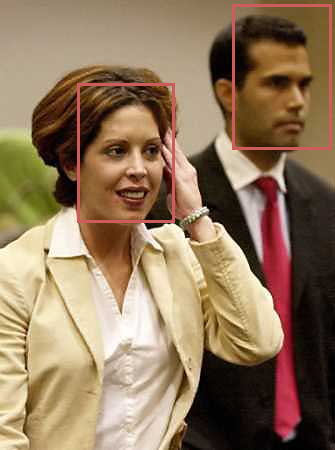

In [6]:
# load image
img_filepath = "./data/face_det.png"
img = imageio.imread(img_filepath)[:, :, :3]

# find faces
(preds,) = model.predict(img)

# visualize predictions
pil_img = ff.utils.vis.render_predictions(img, preds)
img_save_path = "./data/pred_image.png"
pil_img.save(img_save_path)
display(Image.open("data/pred_image.png"))

The above image is from [FDDB dataset](http://vis-www.cs.umass.edu/fddb/).